HMP
==========


![](plots/general_illustration.png)

> [!NOTE]
> The paper on HMP is published at Imaging Neuroscience: [Trial-by-trial detection of cognitive events in neural time-series](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00400/125469/Trial-by-trial-detection-of-cognitive-events-in)


HMP is an open-source Python package to analyze neural time-series (e.g. EEG) to estimate Hidden Multivariate Patterns (HMP).  HMP is described in Weindel, van Maanen & Borst (2024, [paper](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00400/125469/Trial-by-trial-detection-of-cognitive-events-in)
) and is a generalized and simplified version of the HsMM-MVPA method developed by Anderson, Zhang, Borst, & Walsh  ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)).

As a summary of the method, an HMP model parses the reaction time into a number of successive events determined based on patterns in a neural time-serie. Hence any reaction time can then be described by a number of cognitive events and the duration between them estimated using HMP. The important aspect of HMP is that it is a whole-brain analysis (or whole scalp analysis) that estimates the onset of events on a single-trial basis. These by-trial estimates allow you then to further dig into any aspect you are interested in a signal:
- Describing an experiment or a clinical sample in terms of events detected in the EEG signal
- Describing experimental effects based on the time onset of a particular event
- Estimating the effect of trial-wise manipulations on the identified event presence and time occurrence (e.g. the by-trial variation of stimulus strength or the effect of time-on-task)
- Time-lock EEG signal to the onset of a given event and perform classical ERPs or time-frequency analysis based on the onset of a new event
- And many more (e.g. evidence accumulation models, classification based on the number of events in the signal,...)

# Documentation

The package is available through *pip*.
A way of using the package is to use a conda environment (see [anaconda](https://www.anaconda.com/products/distribution>) for how to install conda):

> [!WARNING]
> We are currently moving to 1.0.0 with important changes to the API. New users can either use the latest stable release (0.5.0, install from `pip` as below and see previous version of the [docs](https://github.com/GWeindel/hmp/tree/b26ab6939e8221475af19914da8dddc02df55ca0)) but whose structure will be deprecated or use the upcoming beta for the v1.0.0-b.1 but accept the risk of name changes and bugs up to the final verison of 1.0.0


```bash
    conda create -n hmp 
    conda activate hmp
    conda install pip #if not already installed
    pip install hmp #or cloning from github, see below
```

For the cutting edge version you can clone the repository using *git* (if git already installed)

Open a terminal and type:

    $ git clone https://github.com/gweindel/hmp.git
    $ git switch devel #Optional, bleeding edge version 
    
   
Then move to the clone repository and run 
    
    $ pip install -e .

After either installation path you can import hmp in your favorite python IDE through:

```python
    import hmp
```

## To get started
To get started with the code:
- Check the demo below 
- Inspect the tutorials:
    - [General aspects on HMP (tutorial 1)](docs/source/notebooks/1-How_HMP_works.ipynb)
    - [The different estimation methods (tutorial 2)](docs/source/notebooks/2-The_different_model_classes.ipynb)
    - [Applying HMP to real data (tutorial 3)](docs/source/notebooks/3-Applying_HMP_to_real_data.ipynb)
    - [Load your won EEG data ](docs/source/notebooks/Data_loading.ipynb)


## Demo on simulated data

The following section will quickly walk you through an example usage in simulated data (using [MNE](https://mne.tools/dev/auto_examples/simulation/index.html)'s simulation functions and tutorials)

First we load the packages necessary for the demo on simulated data

### Importing libraries


In [1]:
## Importing these packages is specific for this simulation case
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from hmp import simulations#that module is only to simulate things, no need to import when analyzing data

## Importing HMP as you would to analyze data
import hmp


### Simulating data

In the following code block we simulate 200 trials with four HMP events defined as the activation of four neural sources (in the source space of MNE's sample participant). This is not code you would need for your own analysis except if you'd want to simulate and test properties of HMP models. All four sources are defined by a location in sensor space, an activation amplitude and a distribution in time (here a gamma with shape and scale parameters) for the onsets of the events on each trial. The simulation functions are based on this [MNE tutorial ](https://mne.tools/stable/auto_examples/simulation/simulated_raw_data_using_subject_anatomy.html).

[!IMPORTANT] It can take a while to simulate data, you can also just download the corresponding simulation files (`dataset_README_raw_generating_events.npy` and `dataset_README_raw.fif`) and place it in the same folder from where you are running this notebook

In [2]:
cpus = 1 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM

n_trials = 200 #Number of trials to simulate, we use 200 to get nice ERPs but you can reduce for speed

##### Here we define the sources of the brain activity (event) for each trial
sfreq = 500#sampling frequency of the signal
n_events = 4 #how many events we want to simulate
frequency = 10.#Frequency of the event defining its duration, half-sine of 10Hz = 50ms
amplitude = .25e-7 #Amplitude of the event in nAm, defining signal to noise ratio
shape = 2 #shape of the gamma distribution
scales = np.array([50, 150, 200, 250, 100])/shape #Mean duration of the time between each event in ms
names = simulations.available_sources()[[22,33,55,44,0]]#Which source to activate for each event (see atlas when calling simulations.available_sources())

sources = []
for source in zip(names, scales):#One source = one frequency/event width, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency, amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, 'dataset_README',  overwrite=False, sfreq=sfreq, seed=1)
#load electrode position, specific to the simulations
positions = simulations.positions()

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/simulations.py:220: UserWarning: /home/gabriel/ownCloud/projects/RUGUU/hmp/./dataset_README_raw.fif exists no new simulation performed
  warn(f"{subj_file} exists no new simulation performed", UserWarning)


### Creating the event structure and plotting the raw data

To recover the data we need to create the event structure based on the triggers created during simulation. This is the same as analyzing real EEG data and recovering events in the stimulus channel. In our case the value 1 signals the onset of the stimulus and 6 the moment of the response. Hence a trial is defined as the times occuring between the triggers 1 and 6.

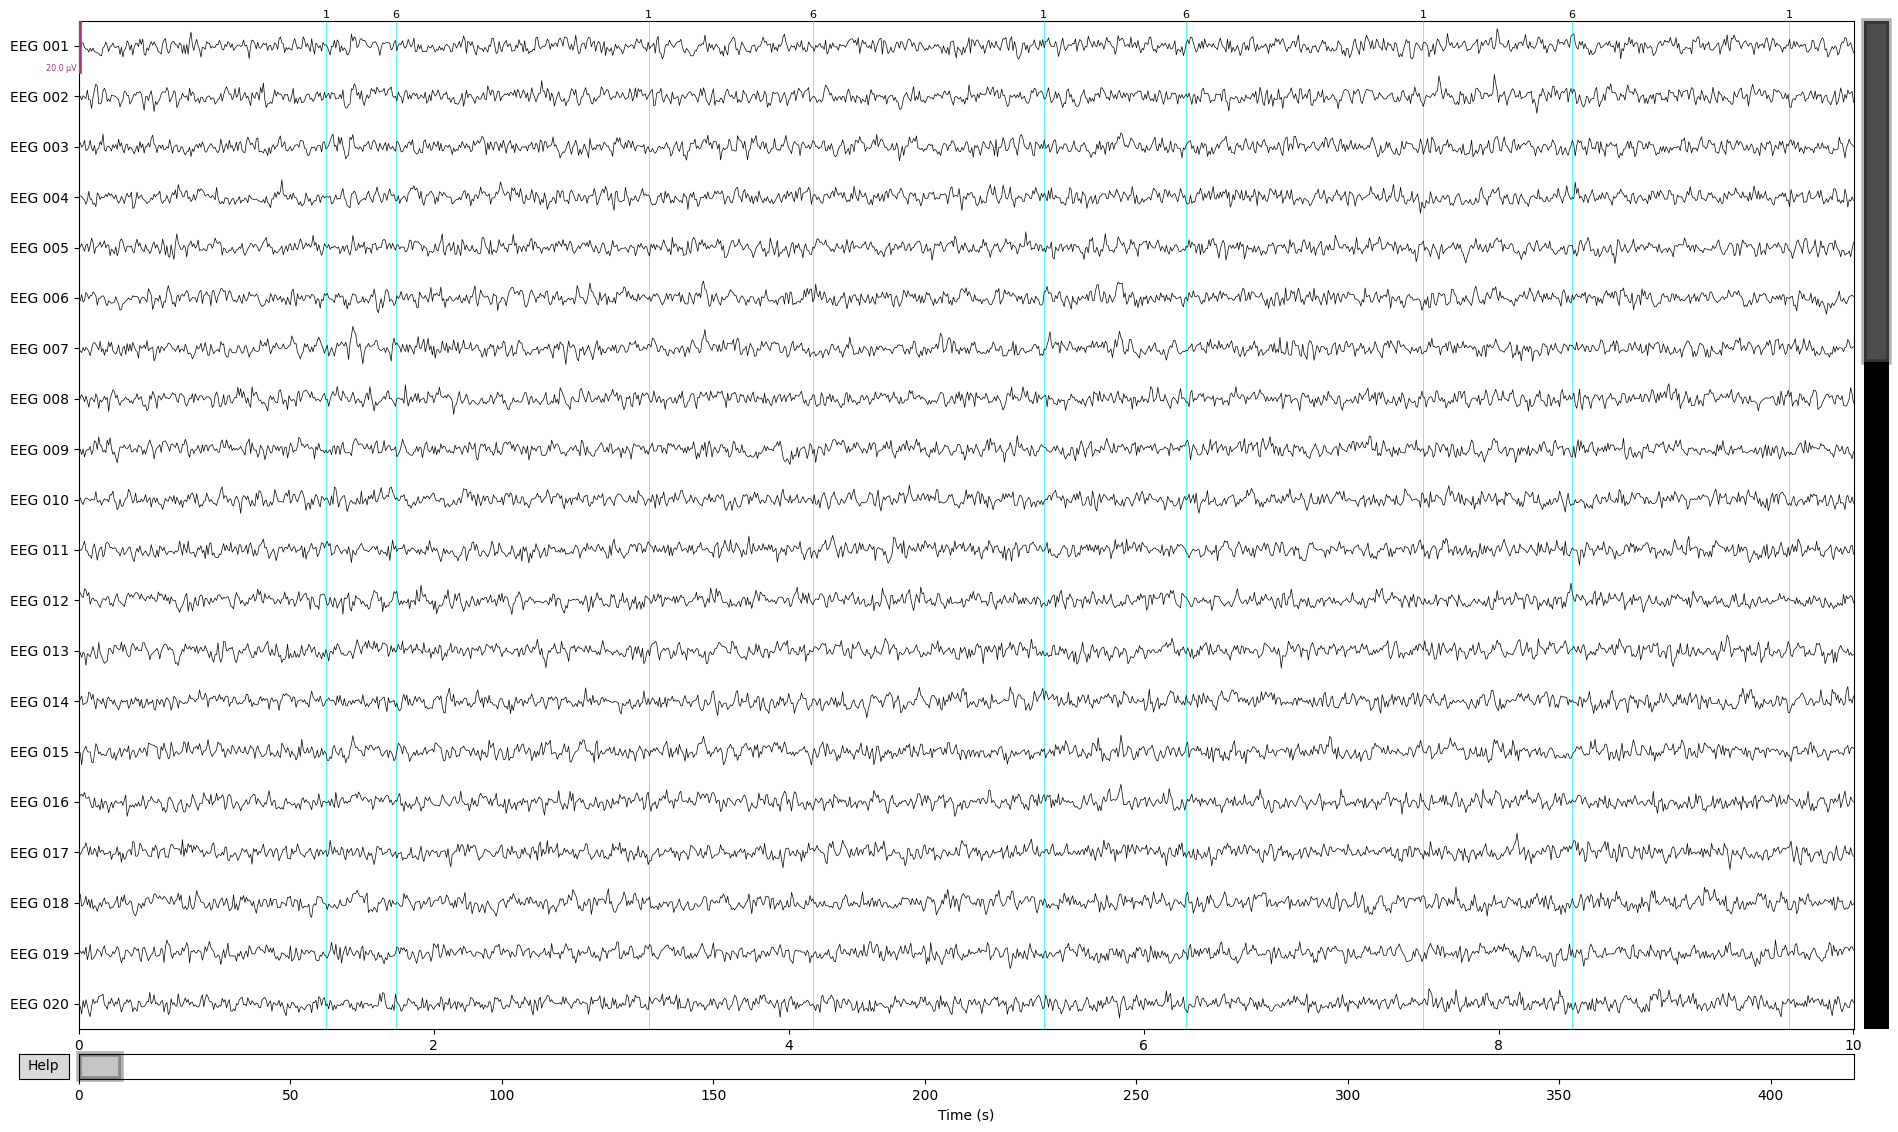

In [3]:
#Recovering the events to epoch the data (in the number of trials defined above)
generating_events = np.load(file[1])
resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}
#Keeping only stimulus and response triggers
events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

#Visualising the raw simulated EEG data
import mne
raw = mne.io.read_raw_fif(file[0], preload=False, verbose=False)
raw.pick_types(eeg=True).plot(scalings=dict(eeg=1e-5), events=events, block=True);

![png](README_files/README_7_1.png)

### Recovering number of events as well as actual by-trial variation

To see how well HMP does at recovering by-trial events, first we get the ground truth from our simulation. Unfortunately, with an actual dataset you don’t have access to this, of course. 

In [4]:
%matplotlib inline
#Recover the actual time of the simulated events
sim_event_times = np.reshape(np.ediff1d(generating_events[:,0],to_begin=0)[generating_events[:,2] > 1], \
           (n_trials, n_events+1))
sim_event_times_cs = np.cumsum(sim_event_times, axis=1)

## Demo for a single participant in a single condition based on the simulated data

First we read the EEG data as we would for a single participant

In [5]:
# Reading the data
epoch_data = hmp.io.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)


Processing participant /home/gabriel/ownCloud/projects/RUGUU/hmp/./dataset_README_raw.fif's raw eeg
200 trials were retained for participant /home/gabriel/ownCloud/projects/RUGUU/hmp/./dataset_README_raw.fif



HMP uses [xarray](https://docs.xarray.dev/en/stable/) named dimension matrices, allowing to directly manipulate the data using the name of the dimensions:



<xarray.Dataset> Size: 87MB
Dimensions:      (participant: 1, epoch: 200, channel: 59, sample: 917)
Coordinates:
  * epoch        (epoch) int64 2kB 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
  * channel      (channel) <U7 2kB 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
  * sample       (sample) int64 7kB 0 1 2 3 4 5 6 ... 911 912 913 914 915 916
    event_name   (epoch) object 2kB 'stimulus' 'stimulus' ... 'stimulus'
    rt           (epoch) float64 2kB 0.394 0.926 0.802 ... 1.082 0.312 0.376
  * participant  (participant) <U2 8B 'S0'
Data variables:
    data         (participant, epoch, channel, sample) float64 87MB 4.141e-07...
Attributes:
    sfreq:             500.0
    offset:            0
    lowpass:           40.0
    highpass:          0.10000000149011612
    lower_limit_rt:    0
    upper_limit_rt:    inf
    reject_threshold:  None
    n_trials:          200


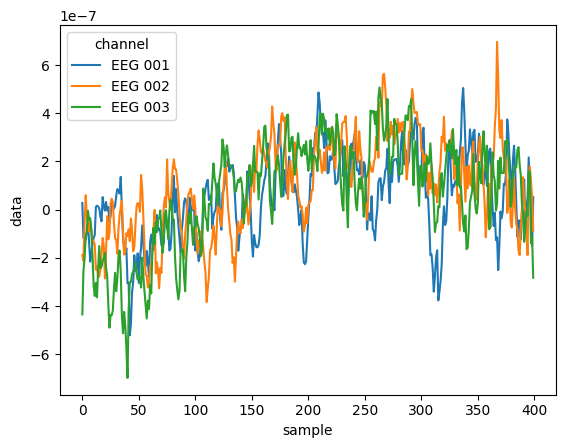

In [6]:
#example of usage of xarray
print(epoch_data)
epoch_data.sel(channel=['EEG 001','EEG 002','EEG 003'], sample=range(400))\
    .data.groupby('sample').mean(['participant','epoch']).plot.line(hue='channel');

Next we preprocess the data by applying a spatial principal components analysis (PCA) to reduce the dimensionality of the data. 

In this case we choose 5 principal components for commodity and speed.

In [7]:
preprocessed = hmp.preprocessing.Preprocessing(epoch_data, n_comp=5, copy=True)

# HMP model

Once the data is in the expected format, we can initialize an HMP object; note that no estimation is performed yet.


In [8]:
# Create the expected 50ms halfsine template
expected_pattern = hmp.patterns.HalfSine.create_expected(sfreq=epoch_data.sfreq, width=50)
# Correlate this pattern with the data
trial_data = hmp.trialdata.TrialData.from_preprocessed(preprocessed=preprocessed.data, pattern=expected_pattern.template)
# Create a standard one-parameter distribution that separate event peaks
time_distribution = hmp.distributions.Gamma()

#Build all this in a model
model = hmp.models.CumulativeMethod(expected_pattern, time_distribution)

## Estimating an HMP model

We can directly fit an HMP model without giving any info on the number of events (see tutorial 2 for a detailed explanation of the following cell:

In [9]:
# Estimate model parameters and transform the data into event probability space
loglikelihood, estimates = model.fit_transform(trial_data)

  0%|          | 0/388 [00:00<?, ?it/s]

Transition event 1 found around time 50.0
Transition event 2 found around time 216.0
Transition event 3 found around time 426.0
Transition event 4 found around time 682.0

All events found, refitting final combination.
Estimating 4 events model


### Visualizing results of the fit

In the previous cell we initiated an HMP model looking for default 50ms half-sine in the EEG signal. The method discovered four events, and therefore five gamma-distributed time distributions with a fixed shape of 2 and an estimated scale. We can now inspect the results of the fit.

We can directly take a look to the topologies and latencies of the events by calling ```hmp.visu.plot_topo_timecourse```



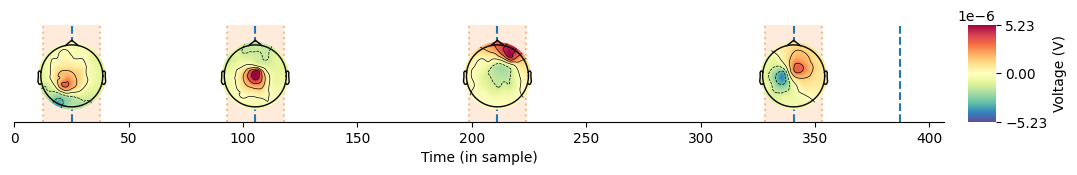

In [10]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates, #Data and estimations 
                               positions,#position of the electrodes and initialized model
                               magnify=1, sensors=False)#Display control parameters

This shows us the electrode activity on the scalp as well as the average time of occurrence of the events.

But HMP doesn't provide point estimate but location probability of each of the detected event and that for each trial, example for the last simulated trial

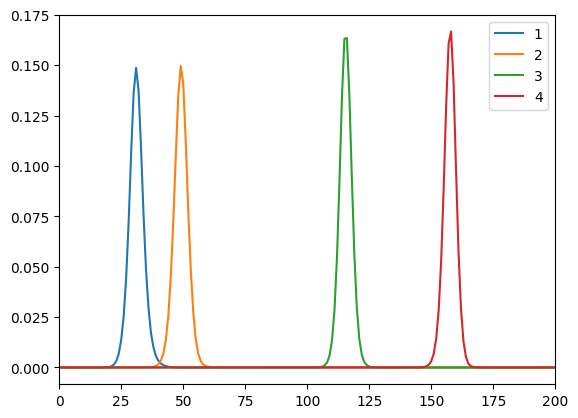

In [11]:
plt.plot(estimates.isel(trial=-1), label=[1,2,3,4])
plt.xlim(0,200)
plt.legend()


This then shows the likeliest event onset location in time for the last simulated trial!

## Comparing with ground truth

As we simulated the data we have access to the ground truth of the underlying generative events. We can then compare the generated single trial peaks for each event with those estimated from the HMP model

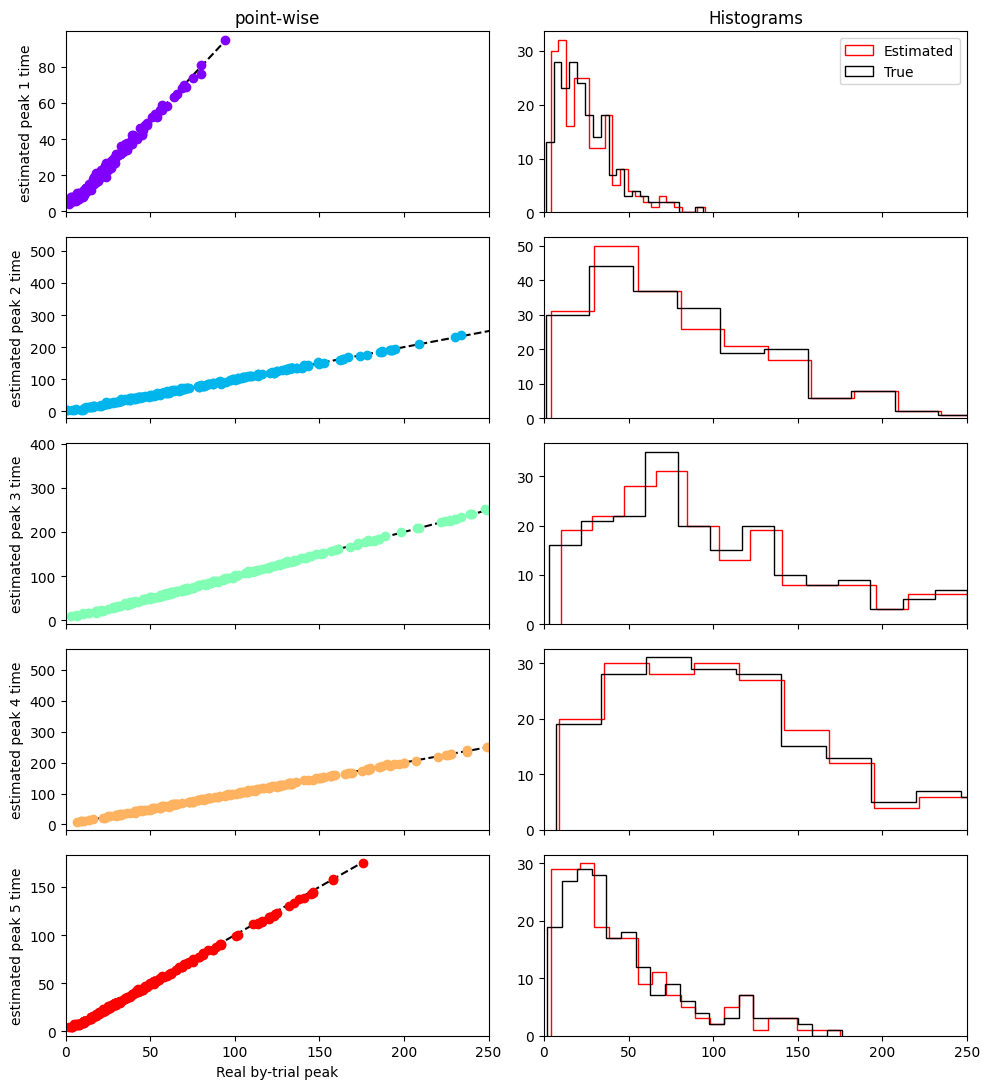

In [12]:
estimated_times = hmp.utils.event_times(estimates, duration=True, mean=False, add_rt=True).T
colors = plt.cm.rainbow(np.linspace(0, 1, 5))
fig, ax = plt.subplots(n_events+1,2, figsize=(10,2.5*n_events+1), dpi=100, sharex=True)
i = 0
ax[0,0].set_title('point-wise')
ax[0,1].set_title('Histograms')
ax[-1,0].set_xlabel(f'Real by-trial peak')

for event in estimated_times:
    ax[i,0].plot([np.min(event), np.max(event)], [np.min(event), np.max(event)],'--', color='k')

    ax[i,0].plot(sim_event_times[:,i], event, 'o', color=colors[i])
    ax[i,0].set_ylabel(f'estimated peak {i+1} time')
    ax[i,1].hist(event, color='red', bins=20, histtype='step', label='Estimated')
    ax[i,1].hist(sim_event_times[:,i].T, color='k', bins=20, histtype='step', label='True')
    i+= 1
ax[0,-1].legend()
plt.xlim(0,250)
plt.tight_layout();


We see that every events gets nicely recovered even on a by-trial basis!


# We have by-trial estimates. Now what?

HMP just helped us estimate at which time point single-trial events occured. There are plenty of things to do with this information.

As an example consider how average curve of traditional event related potentials (ERP) in EEG are a bad representation of the underlying single-trial event. In the following cell we do the average ERP electrode activity for 4 subselected electrodes in the classical way (stimulus centered)

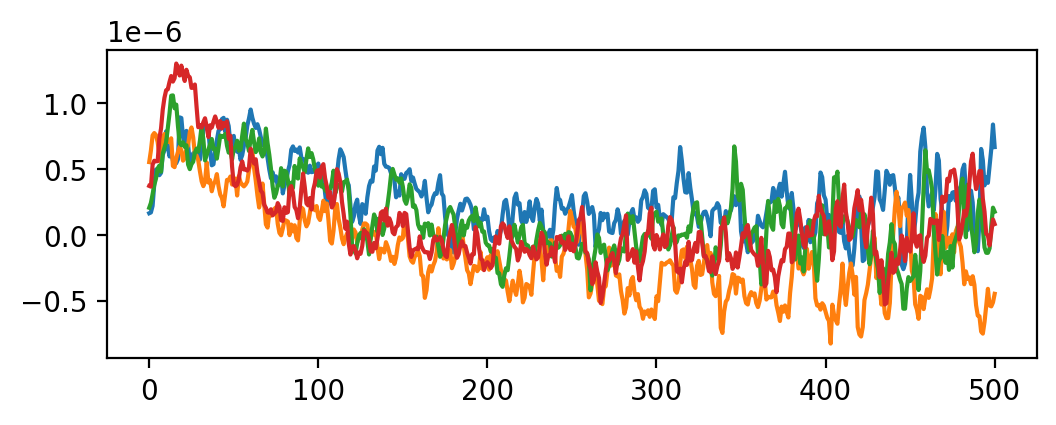

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6,2), sharey=True, sharex=True, dpi=200)
colors = iter([plt.cm.tab10(i) for i in range(10)])

#Cherry picked electrodes
channels = ['EEG 031', 'EEG 039', 'EEG 040', 'EEG 048']
#HMP times
times = hmp.utils.event_times(estimates, mean=False, add_rt=True, add_stim=True)

centered_onstim = hmp.utils.centered_activity(
                epoch_data.stack({'trial':['participant','epoch']}).data, 
                times, channels, event=0, n_samples=500)

for channel in channels:
    c = next(colors)
    plt.plot(centered_onstim.sel(channel=channel).data.mean('trial'))

Note that the signal overall doesn't look like the half-sine pattern we simulated. This is because the by-trial time-jitter makes the average ERP **when centered on stimulus** smeared out.

If however we were to average the signal but centered on the single-trial times detected by HMP the picture is this one:

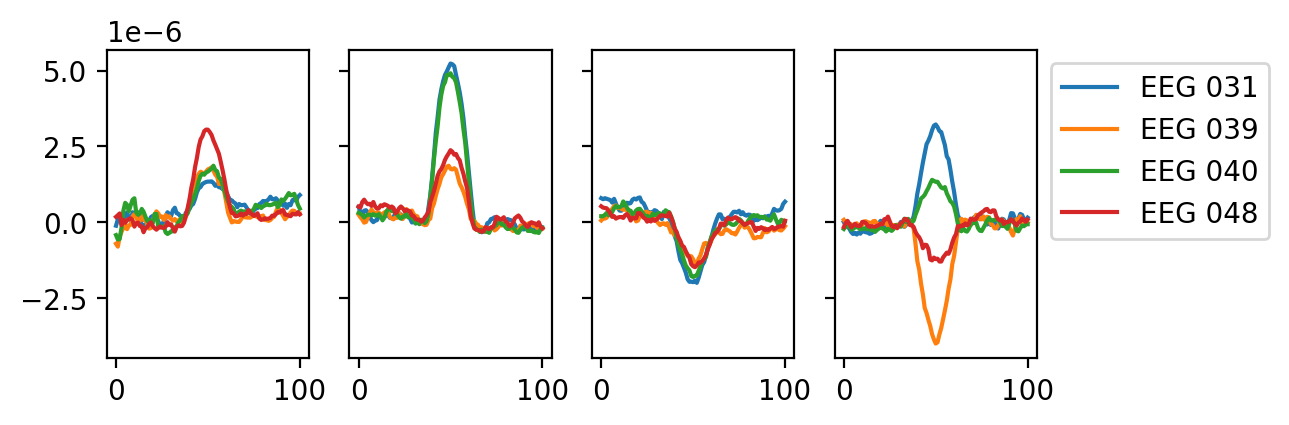

In [14]:
fig, ax = plt.subplots(1,n_events, figsize=(6,2), sharey=True, sharex=True, dpi=200)

#Cherry picked electrodes
channels = ['EEG 031', 'EEG 039', 'EEG 040', 'EEG 048']
#HMP times
times = hmp.utils.event_times(estimates, mean=False, add_rt=True, add_stim=True)

for event in range(n_events):
    centered_onev = hmp.utils.centered_activity(epoch_data, 
                times, channels, event=event+1, n_samples=50, baseline=-50)
    colors = iter([plt.cm.tab10(i) for i in range(10)])
    for channel in channels:
        c = next(colors)
        ax[event].plot(centered_onev.sel(channel=channel).data.mean('trial'), label=channel)
ax[-1].legend(bbox_to_anchor=(1,1));

Compared to the traditional ERP representation we see that HMP provides a much better view of the underlying single-trial activities than the tradition ERP (remember we simualted half-sines).

Now HMP is not merely a method to look at ERPs or by-trial times. A lot can be done once the estimation has been made, for example:
- Connectivity analysis starting from each event onset
- Time/frequency decomposition
- Single-trial signal analysis with, e.g. a single-trial covariate
- and so on 

### Follow-up

For examples on how to use the package on real data, or to compare event time onset across conditions see the tutorial notebooks:
- [General aspects on HMP (tutorial 1)](docs/source/notebooks/1-How_HMP_works.ipynb)
- [The different estimation methods (tutorial 2)](docs/source/notebooks/2-The_different_model_classes.ipynb)
- [Applying HMP to real data (tutorial 3)](docs/source/notebooks/3-Applying_HMP_to_real_data.ipynb)
- [Load your won EEG data ](docs/source/notebooks/Data_loading.ipynb)